In [2]:
#!pip install sklearn
#!pip install -U imbalanced-learn

In [3]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
import statistics

In [4]:
baselist = []
threemonth = []
twentyfour = []
dupcount = []

data = pd.read_csv('updatedspreadnew.csv')

for index, row in data.iterrows():
    if data.at[index, 'MONTH'] == 0:
        baselist.append(row)
    if data.at[index, 'MONTH'] == 3:
        threemonth.append(row)
    if data.at[index, 'MONTH'] == 24:
        twentyfour.append(row)
baseline = pd.DataFrame(data = baselist)
three = pd.DataFrame(data = threemonth)
twentyfour1 = pd.DataFrame(data = twentyfour)

baseline = baseline.reset_index()
three = three.reset_index()
twentyfour1 = twentyfour1.reset_index()

In [5]:
# checking the percentage of missing values in each variable
a = data.isnull().sum()/len(data)*100

# saving missing values in a variable
# saving column names in a variable
variables = data.columns
variable = [ ]
for i in range(0,376):
    if a[i] > 20:   #setting the threshold as 20%
       variable.append(variables[i])
variable #the ones that have more than 20% missing values
baseline = baseline.drop(variable, axis = 1)
three = three.drop(variable, axis = 1)
twentyfour1 = twentyfour1.drop(variable, axis = 1)
newdata = data.drop(variable, axis = 1)


In [6]:
#finding categorical variables that have values that range from 0-20

categ = []  
number = []
uniqueValues = newdata.nunique() #finds number of unique values in each variable
uniqueValues = pd.DataFrame(data = uniqueValues)

for index, row in uniqueValues.iterrows():
    if uniqueValues.at[index, 0]<= 20:
        categ.append(index)
    if uniqueValues.at[index, 0] >= 20:
         number.append(index)
            
#creating dataframes with just numerical variables in each df            
baselinenum = baseline.drop(categ, axis = 1)
threenum = three.drop(categ, axis = 1)
twentyfournum = twentyfour1.drop(categ, axis = 1)

#dataframes with just categorical variables in each df
baselinecat = baseline.drop(number, axis = 1)
threecat = three.drop(number, axis = 1)
twentyfourcat = twentyfour1.drop(number, axis = 1)


#newdata.to_csv('newdata.csv', encoding = 'ISO-8859-1')


In [7]:
# imputation by mean
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

# impute by mean numerical values in baseline df
for column in number: 
    if (baseline[column].isnull().values.any()) & (baseline.dtypes[column] != object):
        imp_mean.fit(baseline[column].values.reshape(-1,1))
        SimpleImputer()
        baseline[column] = imp_mean.transform(baseline[[column]].values.reshape(-1,1))
        
# impute by mean numerical values in three df
for column in number: 
    if (three[column].isnull().values.any()) & (three.dtypes[column] != object):
        imp_mean.fit(three[column].values.reshape(-1,1))
        SimpleImputer()
        three[column] = imp_mean.transform(three[[column]].values.reshape(-1,1))

# impute by mean numerical values in twentyfour1 df
for column in number: 
    if (twentyfour1[column].isnull().values.any()) & (twentyfour1.dtypes[column] != object):
        imp_mean.fit(three[column].values.reshape(-1,1))
        SimpleImputer()
        twentyfour1[column] = imp_mean.transform(twentyfour1[[column]].values.reshape(-1,1))

In [8]:
# imputation by mode
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# impute by mode categorical values in baseline df
for column in categ: 
    if (baseline[column].isnull().values.any()):
        imp_mode.fit(baseline[column].values.reshape(-1,1))
        SimpleImputer()
        baseline[column] = imp_mean.transform(baseline[[column]].values.reshape(-1,1))

# impute by mode numerical values in three df
for column in categ: 
    if (three[column].isnull().values.any()):
        imp_mode.fit(three[column].values.reshape(-1,1))
        SimpleImputer()
        three[column] = imp_mean.transform(three[[column]].values.reshape(-1,1))
        
# impute by mean numerical values in twentyfour1 df
for column in categ: 
    if (twentyfour1[column].isnull().values.any()):
        imp_mean.fit(three[column].values.reshape(-1,1))
        SimpleImputer()
        twentyfour1[column] = imp_mean.transform(twentyfour1[[column]].values.reshape(-1,1))

In [9]:
# drop any bad columns 

baseline_final = baseline.drop(columns = ['DATE_LWHF', 'VISIT_DATE', 'DOB', 'DSCAN'])
three_final = three.drop(columns = ['DATE_LWHF', 'VISIT_DATE', 'DOB', 'DSCAN'])
twentyfour_final = twentyfour1.drop(columns = ['DATE_LWHF', 'VISIT_DATE', 'DOB', 'DSCAN'])

In [10]:
# add label column 
twentyfour_final['Label'] = 0

In [11]:
# if lvef <50, change label to 1
for num in range(71):
    if twentyfour_final.iloc[num]['vol5_lvef'] < 50:
        twentyfour_final.loc[num, 'Label'] = 1

In [12]:
# if lvef decrease by 10, change label to 1
for num in range(71):
    if three_final.iloc[num]['vol5_lvef'] - twentyfour_final.iloc[num]['vol5_lvef'] > 10:
        twentyfour_final.loc[num, 'Label'] = 1

In [13]:
temp = pd.DataFrame()
for i in range(71):
    if twentyfour_final.iloc[i]['Label'] == 1:
        temp = temp.append(twentyfour_final.iloc[i])
        temp = temp.append(twentyfour_final.iloc[i])

In [14]:
# confusion matrix funciton
def confusionMatrix(predicted, actual, threshold):
    if len(predicted) != len(actual): return -1
    tp = 0.0
    fp = 0.0
    tn = 0.0
    fn = 0.0
    for i in range(len(actual)):
        if actual[i] > 0.5: #labels that are 1.0 (positive examples)
            if predicted[i] > threshold:
                tp += 1.0 #correctly predicted positive
            else:
                fn += 1.0 #incorrectly predicted negative
        else: #labels that are 0.0 (negative examples)
            if predicted[i] < threshold:
                tn += 1.0 #correctly predicted negative
            else:
                fp += 1.0 #incorrectly predicted positive
    rtn = [tp, tn, fp, fn]
    return rtn

In [15]:
# normalization function 
from sklearn.preprocessing import MinMaxScaler
def normalize(X_train): 
    norm = MinMaxScaler().fit(X_train)
    X_train_norm = norm.transform(X_train)
    return(X_train_norm)

In [16]:
# one hot encoding 
from sklearn.preprocessing import OneHotEncoder
def one_hot(X_train): 
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(X_train)
    OneHotEncoder(handle_unknown='ignore')
    enc.transform(X_train)

In [17]:
# Smote
#smt = SMOTE()
#X_train, y_train = smt.fit_sample(X_train, y_train)

Text(0, 0.5, 'Label')

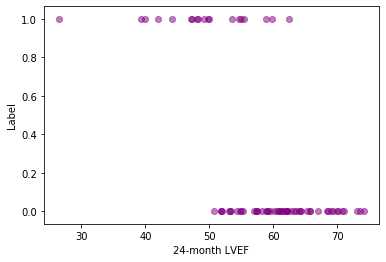

In [18]:
# Visualize 0s vs 1s before model 
plt.scatter(x = twentyfour_final['vol5_lvef'], y = twentyfour_final['Label'], alpha = .5, color = 'purple')
plt.xlabel('24-month LVEF')
plt.ylabel('Label')

52

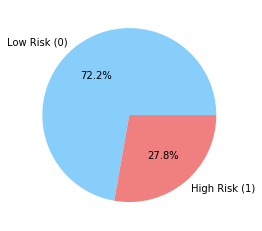

In [19]:
zero = 0 
one = 1
for value in twentyfour_final['Label']:
    if value ==0: 
        zero = zero + 1
    if value ==1: 
        one = one +1
        
sizes = [zero, one]
plt.pie(sizes, labels = ['Low Risk (0)', 'High Risk (1)'], colors = ['lightskyblue', 'lightcoral'], autopct='%1.1f%%')
zero

In [20]:
# Separate majority and minority classes
df_majority = twentyfour_final[twentyfour_final['Label']==0]
df_minority = twentyfour_final[twentyfour_final['Label']==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, replace=True,n_samples=52, random_state=123)
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled

,index,Unnamed: 0,MONTH,ID,bsa,mesa,hr_mesa,sys_bp_mesa,dia_bp_mesa,hct,...,pret1_lvmean,pret1_lvseptum,t2_lvmean,t2_meanseptum,BMI,VOL5_SV,QSTRAIN_MEDIS,LIP_MOD_MO,age,Label
0,2,11,24,5,1.904005,1,67.0,117.000000,77.000000,42.7,...,1039.0,1018.0,49.000000,48.50000,30.489624,55.58,-17.200,-17.820871,53,0
1,5,14,24,6,2.466079,1,65.0,107.106061,64.136364,32.5,...,964.0,959.0,53.000000,53.00000,41.524489,112.32,-15.730,-17.820871,38,0
3,11,20,24,8,1.835605,1,80.0,99.000000,57.000000,39.1,...,996.0,1013.0,54.000000,53.00000,33.632196,47.62,-23.500,-17.820871,72,0
4,14,23,24,9,1.608025,1,66.0,105.000000,73.000000,35.9,...,990.0,1005.0,54.000000,52.00000,26.141327,80.40,-24.800,-17.820871,31,0
5,17,29,24,11,1.791854,1,67.0,111.000000,58.000000,35.8,...,1003.0,1000.0,51.000000,51.00000,33.723987,53.92,-20.300,-17.820871,72,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,140,182,24,81,2.205987,1,63.0,103.000000,59.000000,47.8,...,1014.0,1023.0,49.000000,49.00000,27.545079,53.67,-15.670,-17.820871,53,1
47,143,185,24,80,1.543845,1,55.0,118.000000,50.000000,39.4,...,1038.0,1051.0,51.000000,50.00000,23.302011,51.96,-22.600,-17.820871,69,1
26,80,111,24,51,1.930627,1,54.0,106.000000,66.000000,40.0,...,1032.0,1029.0,50.000000,49.50000,29.337703,77.28,-15.900,-17.820871,67,1
50,152,196,24,86,2.001248,1,69.0,144.000000,86.000000,40.8,...,1074.0,1099.0,51.000000,50.00000,29.136902,71.75,-10.180,-17.820871,59,1


In [21]:
#Penalized Regression Model handling missing values 
def good():
    X = df_upsampled.drop(columns = 'Label').values
    y = df_upsampled['Label'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(X_train)
    OneHotEncoder(handle_unknown='ignore')
    enc.transform(X_train)

    model = Ridge()
    model.fit(X_train,y_train)
    y_predicted = model.predict(X_test)
    cm = confusionMatrix(y_predicted, y_test, .5)
    accuracy = (cm[0] + cm[1])/ (cm[0] + cm[1] + cm[2] + cm[3])
    return(accuracy)
total = 0
for i in range(100):
    total = good() + total
avg = total/100
avg

accuracies_good = []
for i in range(100):
    accuracies_good.append(good())

In [22]:
res = statistics.pstdev(accuracies_good)
print(avg)
print(res)

0.827142857142857
0.08156490953296143


In [23]:
#Penalized Regression Model 
def bad():
    X = twentyfour_final.drop(columns = 'Label').values
    y = twentyfour_final['Label'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(X_train)
    OneHotEncoder(handle_unknown='ignore')
    enc.transform(X_train)

    model = Ridge()
    model.fit(X_train,y_train)
    y_predicted = model.predict(X_test)
    cm = confusionMatrix(y_predicted, y_test, .5)
    accuracy = (cm[0] + cm[1])/ (cm[0] + cm[1] + cm[2] + cm[3])
    return(accuracy)

total = 0
for i in range(100):
    total = bad() + total
avg = total/100
avg

accuracies_bad = []
for i in range(100):
    accuracies_bad.append(bad())

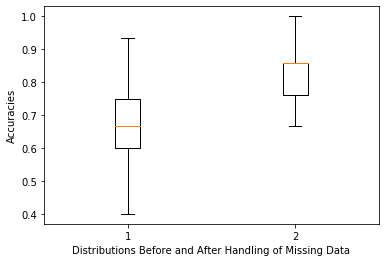

In [24]:
# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot([accuracies_bad, accuracies_good])
plt.xlabel('Distributions Before and After Handling of Missing Data')
plt.ylabel('Accuracies')
plt.show()

In [25]:
res = statistics.pstdev(accuracies_good)
print(avg)
print(res)

0.6626666666666665
0.08156490953296143


In [26]:
#Penalized Regression Model 
X = twentyfour_final.drop(columns = 'Label').values
y = twentyfour_final['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

#sm = SMOTE()
#X_train, y_train = smt.fit_sample(X_train, y_train)

#sm = SMOTE(random_state=42)
#X_res, y_res = sm.fit_resample(X, y)

#X_train, y_train = sm.fit_resample(X, y)

#One Hot encoding
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train)
OneHotEncoder(handle_unknown='ignore')
enc.transform(X_train)


#X_test_norm = norm.transform(X_test)
model = Ridge()
model.fit(X_train,y_train)
y_predicted = model.predict(X_test)
#mse = np.mean(np.square(y_test-y_predicted))
cm = confusionMatrix(y_predicted, y_test, .5)
accuracy = (cm[0] + cm[1])/ (cm[0] + cm[1] + cm[2] + cm[3])

In [27]:
#SVM 
def svm_good():
    X = df_upsampled.drop(columns = 'Label').values
    y = df_upsampled['Label'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(X_train)
    OneHotEncoder(handle_unknown='ignore')
    enc.transform(X_train)

    clf = svm.SVC(kernel='linear', C = 1)
    cv = ShuffleSplit(n_splits=10, test_size=0.1)
    scores = cross_val_score(clf, X, y, cv=cv)
    return(scores.mean())

total = 0
for i in range(10):
    total = svm_good() + total
avg = total/10
avg

accuracies_good = []
for i in range(10):
    accuracies_good.append(svm_good())

In [28]:
res = statistics.pstdev(accuracies_good)
print(avg)
print(res)

0.89
0.022563042992710666


In [29]:
# SVM
clf = svm.SVC(kernel='linear', C = 1)
cv = ShuffleSplit(n_splits=10, test_size=0.1)
scores = cross_val_score(clf, X, y, cv=cv)
scores.mean()

0.7125

In [30]:
def accuracy_score(y_test, y_pred):
    correct = 0
    for num in range(len(y_pred)):
        if y_pred[num] == y_test[num]:
            correct = correct + 1
    return(correct/len(y_pred))

In [31]:
#Random Forest 
def rf_good():
    X = df_upsampled.drop(columns = 'Label').values
    y = df_upsampled['Label'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(X_train)
    OneHotEncoder(handle_unknown='ignore')
    enc.transform(X_train)

    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    return(accuracy_score(y_test, y_pred))

total = 0
for i in range(100):
    total = rf_good() + total
avg = total/100
avg

accuracies_good = []
for i in range(100):
    accuracies_good.append(rf_good())

In [32]:
res = statistics.pstdev(accuracies_good)
print(avg)
print(res)

0.9333333333333322
0.051134520913224006


In [33]:
# Random Forest 
rf = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7333333333333333

In [34]:
# Visualize Confusion Matrix 
data = [['Actual: 0', cm[0], cm[2]], ['Actual: 1', cm[3], cm[1]]]
conmat = pd.DataFrame(data, columns = ['', 'Predicted: 0', 'Predicted: 1'])
conmat.set_index([''])

,Predicted: 0,Predicted: 1
,,
Actual: 0,0.0,3.0
Actual: 1,3.0,9.0


In [35]:
sum = 0
for thing in twentyfour_final['Label']:
    if thing == 1: 
        sum = sum + 1
sum

19

In [36]:
# stratified splitting 
# try 90 - 10 split - triple the number of 1s 
# look at chapter 3 or 4 
# maybe get a graph plot on page 36 
# function to extract most important features 

In [44]:
X = twentyfour_final.drop(columns = 'Label')
y = twentyfour_final['Label']

[1.21119420e-02 1.35303802e-02 0.00000000e+00 1.58903666e-02
 1.05892135e-02 1.61194807e-03 1.23411463e-02 9.50519675e-03
 1.61044248e-02 1.60545714e-02 8.59518875e-03 9.08148488e-03
 3.89592276e-03 5.39208419e-03 1.11898387e-02 6.89960131e-03
 7.31033756e-03 3.33859254e-03 5.09352640e-03 3.39562284e-03
 3.18553146e-03 4.40687808e-03 4.60351690e-03 6.48886630e-03
 3.33686311e-03 4.68793758e-03 3.38554783e-03 4.62176289e-03
 5.47435591e-03 7.32733415e-03 8.44757216e-03 0.00000000e+00
 0.00000000e+00 5.21978022e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.14618449e-03 2.54681510e-03 0.00000000e+00
 3.39950142e-03 6.14018886e-03 3.31035389e-03 0.00000000e+00
 7.33822236e-03 0.00000000e+00 6.30752875e-03 0.00000000e+00
 3.32309612e-03 5.18466341e-04 6.29913654e-04 0.00000000e+00
 4.29036522e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 8.70014326e-03 0.00000000e+00 0.00000000e+00
 1.23425150e-02 0.000000

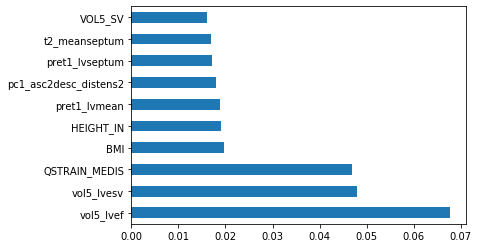

In [47]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [52]:
import seaborn as sns
#get correlations of each features in dataset
corrmat = twentyfour_final.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
#g = sns.heatmap(twentyfour_final[top_corr_features].corr(),annot=True,cmap="RdYlGn")

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>